# Classifying Supernova Spectra in DESI

In a companion notebook we showed what astrophysical transients look like in the spectra recorded by DESI. We not only want to identify the presence of supernova, but also classify what we are seeing:

<img src="figures/sne_filippenko.png" width="500px"/>

The problem is that in 35 million spectra, there is no way to manually inspect all the measurements to see if a supernova, kilonova, or tidal disruption event is "contaminating" the light from a host galaxy. So we need to make the computer do the work for us.

## Machine Learning Tools for Classification

### An Example Classification Problem

In the past 10 years machine learning has advanced tremendously for exactly the kind of classification problem we are facing with the DESI spectra. To illustrate how it works, have a look at the images of cats and dogs shown below.

<img src="figures/cats_and_dogs.png" width="500px"/>

You can tell at a glance how to tell apart images of cats from images dogs without really explaining how you are doing it, right? The human visual cortex is **outstanding** at matching patterns very quickly. But suppose you had 35 million pictures of animals' faces. How would you write a program to automatically tell apart cats from dogs?

Think about the following issues you'd need to solve.
- What distinguishes "catlike" features from "doglike" features?
- How would you represent these features in a piece of code? In other words, how would you "parameterize" the features?
- How would you make the code *robust* so that you can identify cats and dogs even if the image is a little noisy, or slightly rotated, or the animals' heads are facing different directions, and so on?

As you can tell, this is going to get very tricky, very fast. If you write a piece of traditional analysis code, you'll need to think about *many* different cases that the code has to handle. **It's a hard problem!**

### Classification with Neural Networks

A neural network is a computational device that greatly simplifies the classification problem for you. While the subject of neural networks and deep learning is vast, the cartoon below shows the basic parts of a network:

<img src="figures/nn.jpg" width="600px"/>

The network is made up of simple nodes, or **neurons**, that take some numerical input between 0 and 1 and provide a simple numerical output between 0 and 1. The neurons are organized into three groups:
1. A set of input nodes in an input layer.
2. A set of hidden nodes.
3. A set of output nodes in an output layer.

Each neuron in a given layer can be connected to some or all of the neurons in the previous layer and the next layer. Moreover, the connections get **weights** that cause certain neurons to have more or less influence on the output of the network.

##### Input Neurons

In our particular problem, the input neurons would represent the information in the input pixels in an image. For example, if the image of a cat or dog is 64x64 pixels, then we'd have 4096 input neurons, one corresponding to each pixel in the image. And the input value at each neuron could be the total intensity in its corresponding pixel, or the value of the RGB color channels in that pixel.

##### Output Neurons

The output neurons represent the output of the neural network. Since we have a network that is designed to distinguish cat images from dog images, the network has two output. One output neuron gets "activated" when the input image contains a cat, and the second neuron gets "activated" when the input image includes a dog.

##### Hidden Neurons

The hidden neurons are contained in one or more layers, and contain many connections between the layers. These connections all get unique weights. As you train the network on a collection of images, the network adjusts the weights between the neurons as it "learns" how to distinguish cats and dogs with increasing accuracy. The weights in the complex web of connections store the "knowledge" of the network.

**Terminology: Deep Learning**: You have probably heard the term "deep learning" in the media. But what does it mean? It refers to the number of hidden layers in a neural network. Until the mid-2000s, most neural networks had only one hidden layer, because it was computationally difficult to train networks with more hidden layers. But since then advances in software and hardware have enabled training of networks with more hidden layers. So a *deep neural network* refers to one that has 3 or more hidden layers. Training such a network is deep learning.

### Convolutional Neural Networks (CNNs)

Training and using a fully-connected neural network like the one shown above is tricky because there are so many weights. For image analyses there is a shortcut that drastically reduces the size of the network while also making it very robust. These are so-called **convolutional neural networks**, or **CNNs**.

To understand how CNNs work, consider the cartoon image of the cat shown below.

<img src="figures/cat.png" width="400px"/>

The cat's face contains structures organized in a particular pattern: two ears at the top, two eyes below the ears, a nose in the center, a mouth below the nose, and whiskers. If you look closely at the ears, eyes, nose, mouth, and whiskers, you'll notice they are comprised of simple curves and shapes. And these shapes appear again and again in the image.

In other words, the cat's face is a **hierarchy of simple shapes** built up to form a recognizable pattern.

A convolutional neural network takes advantage of the fact that all images are hiearchical and include components that appear across many different pixels. The CNN works by building up simple *filters* trained to look for these components. And the outputs of the filters get combined into a network that can classify images as well or better than a traditional fully-connected network.

### A CNN for Classifying DESI Spectra

In this notebook we'll demonstrate the use of a CNN to classify spectra.

Spectra are even simpler than 2D images, but they do contain hierarchical structure. Look again at the image of spectra at the top of the page. Each spectrum contains a series of emission lines and absorption lines. These are just dips and spikes in the spectrum. And the dips and spikes are combinations of upward- and downward-sloping lines. So with the same CNN technology used to classify images on the internet, we can build a CNN to classify our spectra.

We'll get to that below.

## Additional Resources

Machine learning is a huge topic, but if you are interested in the mathematical details of neural networks I highly recommend the following resources:

1. [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/) by Michael Neilson, a great and relatively gentle introduction to the mathematics of neural networks.
2. [3blue1brown: Neural Networks](https://youtu.be/aircAruvnKk) by Grant Sanderson. A fantastic video series based on Nielson's book. Watch when you have about 90 minutes to kill.
3. [Deep Learning with Python](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438) by Francois Chollet. A nice how-to manual that will get you working on real problems, written by the author of the TensorFlow package.

# Classifying Spectra: A Simple Exercise

Here we're going to train a neural network based on a small set of simulated spectra from the DESI Bright Galaxy Survey. The spectra are saved to an npz archive so first we'll extract and plot a few of them.

## Spectrum Plots

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=14)

Open the archive and list its contents.

In [3]:
spectra = np.load('data/simspectra.npz')
spectra.files

['wave', 'hosts', 'snia', 'snib', 'snic', 'sniip']

Extract the contents of the archive. There should be one wavelength table and 5 flux tables.

In [4]:
wave        = spectra['wave']

host_fluxes = spectra['hosts']

snia_fluxes = spectra['snia']
snib_fluxes = spectra['snib']
snic_fluxes = spectra['snic']
snii_fluxes = spectra['sniip']

Plot one spectrum from each table. Note that the spectra have been **preconditioned** so that our machine learning classifier is easy to train.

1. All spectra were de-redshifted to their rest frame wavelength.
1. Then the spectra were rebinned to increase the signal-to-noise ratio per bin.
1. The spectra were then resampled so that they are all reported on the same wavelength grid.
1. Finally, the fluxes were rescaled so their values always go between 0 and 1.

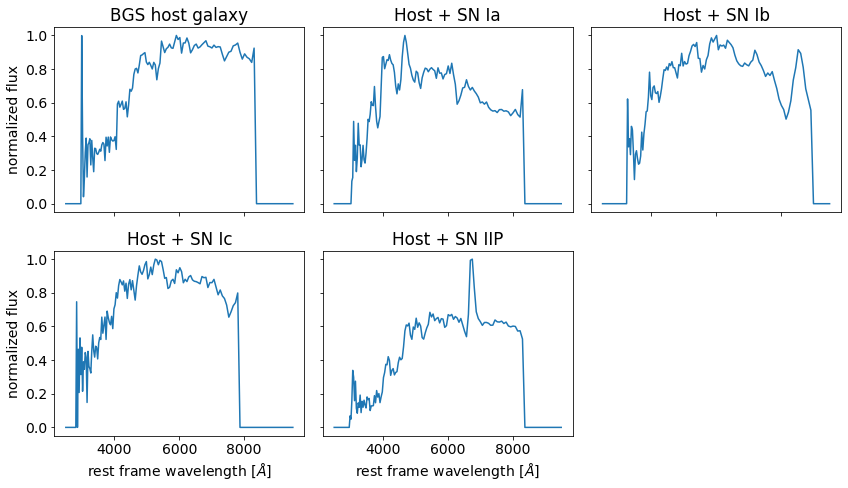

In [5]:
fig, axes = plt.subplots(2,3, figsize = (12,7), tight_layout=True, sharex=True, sharey=True)

ax = axes[0,0]
ax.plot(wave, host_fluxes[0])
ax.set(ylabel='normalized flux',
       title='BGS host galaxy')

ax = axes[0,1]
ax.plot(wave, snia_fluxes[0])
ax.set(title='Host + SN Ia')

ax = axes[0,2]
ax.plot(wave, snib_fluxes[0])
ax.set(title='Host + SN Ib')

ax = axes[1,0]
ax.plot(wave, snic_fluxes[0])
ax.set(xlabel=r'rest frame wavelength [$\AA$]',
       ylabel='normalized flux',
       title='Host + SN Ic')

ax = axes[1,1]
ax.plot(wave, snii_fluxes[0])
ax.set(xlabel=r'rest frame wavelength [$\AA$]',
       title='Host + SN IIP')

axes[1,2].axis('off');

## Set up Classification Data Set

At this point we want to set up a CNN classifier and train it. This requires a couple of steps.

1. We're going to divide the data into two sets: a set of *training* spectra and a set of *testing* or *validation* spectra.
1. Assign numerical labels to each spectrum type. I.e.,
  - hosts = 0
  - SNe Ia = 1
  - SNe Ib = 2
  - SNe Ic = 3
  - SNe IIP = 4
  
The network will then use these numerical codes to classify the spectra.

In [6]:
# Divide the data into variables x and y, where x=spectra and y=our labels.
nbins = len(wave)

x = np.concatenate([host_fluxes, 
                    snia_fluxes,
                    snib_fluxes,
                    snic_fluxes,
                    snii_fluxes
                   ]).reshape(-1, nbins, 1)

In [7]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(len(host_fluxes), 0), 
                        np.full(len(snia_fluxes), 1),
                        np.full(len(snib_fluxes), 2),
                        np.full(len(snic_fluxes), 3),
                        np.full(len(snii_fluxes), 4)
                       ]))

In [8]:
x.shape, y.shape

((752, 150, 1), (752, 5))

#### Training and Testing Samples

Next we're going to split the data into training and testing samples. This is done so that the network doesn't "overtrain" on statistical fluctuations in the data.

We'll use 2/3 of the data for training and 1/3 of the data to test the results of the training.

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.333)

### Designing the CNN

At this point we want to design the machine learning classifier, our convolutional neural network. We're going to use predefined data structures in TensorFlow do to this.

You have a huge amount of freedom to design the architecture of the network. This is both great and awful -- great because the limit is your imagination, and awful because many architectures are suboptimal, and you often have to emperically test several designs before finding one that works.

Here we are going write a function to set up a network with 3 convolutional layers. You could try more or fewer CNN layers and see how the performance is affected.

We are also going to optimize the network based on its **accuracy**, a metric that maximizes the true predictions of the network. We can also train on other metrics like **precision**, which optimizes for fewer false predictions. (That sounds like it should be the same as the accuracy, but it's not.) For a nice discussion of the many different types of metrics one can optimize on, see [this article on wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall).

In [10]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

In [11]:
def network(input_shape, ncat, learning_rate=0.0005, reg=0.003, dropout=0.7, seed=None):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories or classes.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    
    # Set up optimizer, loss function, and optimization metrics.
    model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [12]:
# Define the network here.
# The input shape will have nbins=150 wavelength bins.
# The number of categories is defined by the shape of our y-vector.
# We should have five categories (hosts, SN Ia, Ib, Ic, and IIP).

cnn_model = network((nbins, 1), ncat=y.shape[1])

#### CNN Summary

The function call below will print a summary of the layers in the network.

In total there are 152,405 separate values that can be trained in this network. That means the network has over 150,000 values that need to be filled for it to "learn" how to tell apart a normal BGS galaxy from one contaminated by light from a supernova!

In [13]:
cnn_model.summary()

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 8)            48        
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 8)            32        
_________________________________________________________________
activation (Activation)      (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 16)            64    

### Train (or "Fit") the Network

At this point we're going to use our training set `x_train` and `y_train` to train the network. That is, we're going to run an optimizer that fills the values of the convolutional layers of our CNN and the weights in the dense layer before the output.

We have some freedom in exactly how we train the network (batch size, epochs) that we won't get into here. But suffice to say there are even more knobs you can turn to get optimal performance.

In [14]:
history = cnn_model.fit(x_train, y_train, batch_size=50, epochs=125, validation_data=(x_test, y_test), shuffle=True)

Epoch 1/125
11/11 [==============================] - 1s 68ms/step - loss: 2.8024 - accuracy: 0.2555 - val_loss: 2.7528 - val_accuracy: 0.2351
Epoch 2/125
11/11 [==============================] - 0s 18ms/step - loss: 2.6331 - accuracy: 0.3633 - val_loss: 2.7080 - val_accuracy: 0.2470
Epoch 3/125
11/11 [==============================] - 0s 15ms/step - loss: 2.5279 - accuracy: 0.3593 - val_loss: 2.6692 - val_accuracy: 0.2908
Epoch 4/125
11/11 [==============================] - 0s 16ms/step - loss: 2.4921 - accuracy: 0.4032 - val_loss: 2.6369 - val_accuracy: 0.2271
Epoch 5/125
11/11 [==============================] - 0s 18ms/step - loss: 2.3895 - accuracy: 0.4192 - val_loss: 2.6106 - val_accuracy: 0.2390
Epoch 6/125
11/11 [==============================] - 0s 15ms/step - loss: 2.3178 - accuracy: 0.4830 - val_loss: 2.5909 - val_accuracy: 0.2351
Epoch 7/125
11/11 [==============================] - 0s 16ms/step - loss: 2.2473 - accuracy: 0.5190 - val_loss: 2.5778 - val_accuracy: 0.2191
Epoch 

### CNN Loss and Accuracy

When we train the network there are two numbers we want to keep track of: the loss and the accuracy. Loss is essentially a measure of how badly the network is doing at identifying our spectra. We want it to be as small as possible.

Accuracy is a measure of how well the network is doing at identify the 5 different classes of spectra we simulated. We want this number to be as high as possible.

The plots below show how the loss and accuracy change as a function of time while we're training the network. The blue lines show the loss and accuracy of the training sample; the orange lines show the loss and accuracy of the testing/validation sample. We care about the orange lines. It looks like the network reaches an accuracy of around 70% (`val_acc=0.7`) by the time it's finished training.

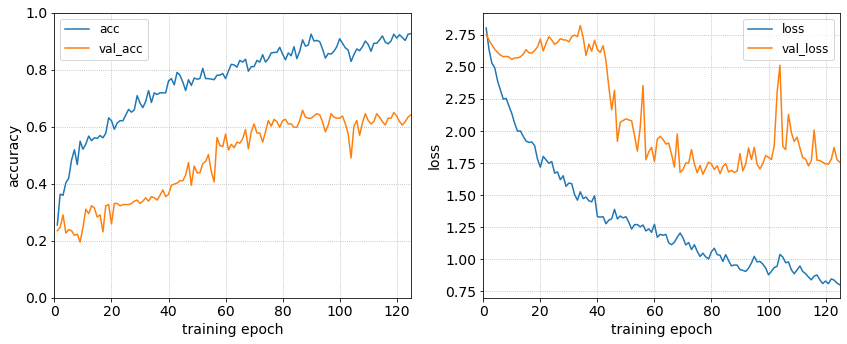

In [15]:
fig, axes = plt.subplots(1,2, figsize=(12,5), sharex=True)

nepoch = len(history.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, history.history['accuracy'], label='acc')
ax.plot(epochs, history.history['val_accuracy'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.,1.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, history.history['loss'], label='loss')
ax.plot(epochs, history.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
#        ylim=(0.,2.0)
      )
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

fig.tight_layout();

### Confusion Matrix

Another way to measure how well the network has performed is by computing a **confusion matrix**. This is a special type of plot that shows how well the network performs on each category of input. I.e., is it good at distinguishing supernovae from host galaxies, but poor at telling apart the different kinds of supernovae? The confusion matrix helps us visualize this.

In [16]:
from sklearn.metrics import confusion_matrix

# We're going to use the test sample to test the predictions of our
# trained CNN now that it's "learned" how to tell apart the different
# supernovae. This isn't ideal... we should really have a third data
# sample independent of the training and testing samples.
y_pred = cnn_model.predict(x_test)

# In the multi-class classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

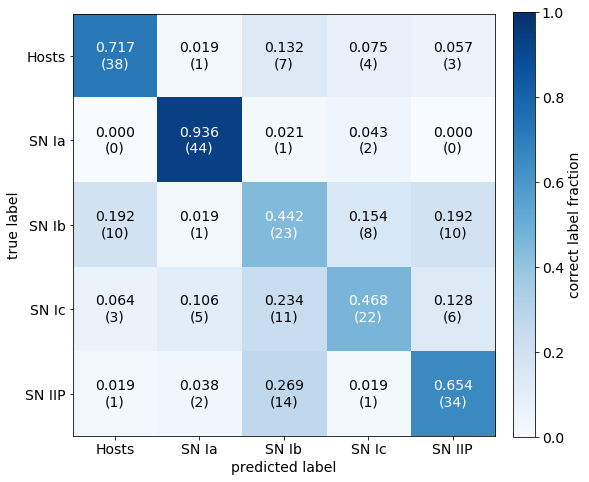

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,7))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

labels = ['Hosts', 'SN Ia', 'SN Ib', 'SN Ic', 'SN IIP']

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')

fig.tight_layout()

#### Interpreting the Confusion Matrix

Understanding the confusion matrix actually isn't that hard. If the CNN is perfectly classifying the various categories, then the true label and the predicted label (the output of the CNN) would match 100%. In this cases only the diagonal squares would appear filled in the matrix; the rest would be blank.

In our case, we see the CNN is really good at classifying Type Ia supernovae; decent at classifying Type IIP core-collapse supernovae; and mediocre at classifying Type Ib and Ic supernvoae. It appears to be mixing up Type Ib and Ic, and is incorrectly claiming that 30% of host galaxies actually contain a Type Ib supernova!

## Improving the Classifier

#### Increasing the Size of the Training Set

There are several ways we can improve our host galaxy and supernova classifier. The most surefire way is to increase the size of our training sample. We chose a 67%/33% split between training and testing. Why don't you try changing this to an 80-20 split using the function call

```x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)```

and then re-run the classifier? Does it make any difference at all? Perhaps we need more data?

#### Changing the Learning Rate and Dropout Rate

The CNN "learns" the correct weights for classification according to a preset rate. Perhaps changing the rate will cause it to optimize in a different way. Try a couple of different values for the learning rate and dropout rate when you create the network model. For example, to try a learning rate of 0.1% and a dropout rate of 80%, you'd declare the model as follows:

```cnn_model = network((nbins, 1), ncat=y.shape[1], learning_rate=0.001, dropout=0.8)```

Does this make any difference in the accuracy, loss, and confusion matrix?

#### Changing the Architecture of the CNN

Maybe we didn't choose the right architecture for our network. Why don't you add or remove one convolutional layer to the network and see what happens?

To **remove** a convolutional layer, just go to the definition of the `network` function and comment out the third `Conv1D` object (the block of code that starts "`with backend.name_scope('Conv_3'):`").

To **add** a convolutional layer, copy the `Conv_3` and after it paste a fourth layer called `Conv_4`.

Train the network in each case and see what happens. Do you get any improvement in performance?

## Conclusions

Deep learning with neural networks is a powerful way to classify data, and our spectral classification problem is much like image classification with CNNs.

Learning how to manage neural networks takes practice, but there are a lot of good resources out there to help you. For a good background see the books by Nielson and Chollet and the video by 3blue1brown. For other types of questions about network optimization, searching on Google is often a good strategy. Then find a problem and play around. The best way to learn is by messing with data!